In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA


In [3]:
# load weights and set these weights to current additive gpmap to 
# check whether x_to_phi is working correctly
mpsa_theta = pd.read_csv('data/mpsa_ge_additive_theta.csv',index_col=[0])
mpsa_theta

,A,C,G,U
0,0.189997,0.245957,-0.215436,-0.222793
1,0.486258,-0.031005,-0.207988,-0.246489
2,-0.325754,-0.315853,1.070888,-0.437522
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,-0.911139,0.000000,0.941255
5,0.943106,-0.495813,0.132037,-0.535949
6,0.499349,-0.032492,-0.294187,-0.189754
7,-0.230271,-0.330037,0.748948,-0.261761
8,-0.159224,-0.083537,-0.097654,0.319998


In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','U']

In [5]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# set parameters to mpsa model 
# this is done to check for validity of updated x_to_phi
gpmap.set_params(theta_0=-2.508132402430794,
                 theta_lc=mpsa_theta.values)

# get test set data.
x_test = test_df['x'].values
y_test = test_df['y'].values

2022-02-22 14:27:08.326226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Updated phi usage
Computed directly from gpmap object

In [6]:
phi = gpmap.x_to_phi(x_test)

### Validate gpmap object usage

Text(0.5, 0, 'phi')

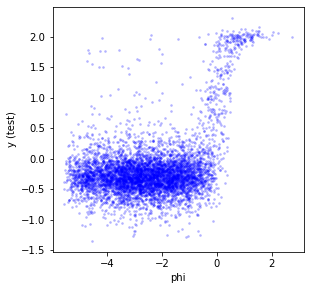

In [7]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(phi,y_test,s=3,alpha=0.2,c='b')
ax.set_ylabel('y (test)')
ax.set_xlabel('phi')

## Create new gpmap to test out with multi-target GE regression

In [8]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet=['A','C','G','T'])

### Create measurement process object(s)

In [9]:
mp_GE_1 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=20)
mp_GE_2 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=50)


In [10]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_GE_1,mp_GE_2])

In [11]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 38)]        0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 36)           0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer_1 (Addit  (None, 1)           37          ['Sequence_only[0][0]']          
 iveGPMapLayer)                                                                                   
                                                                                              

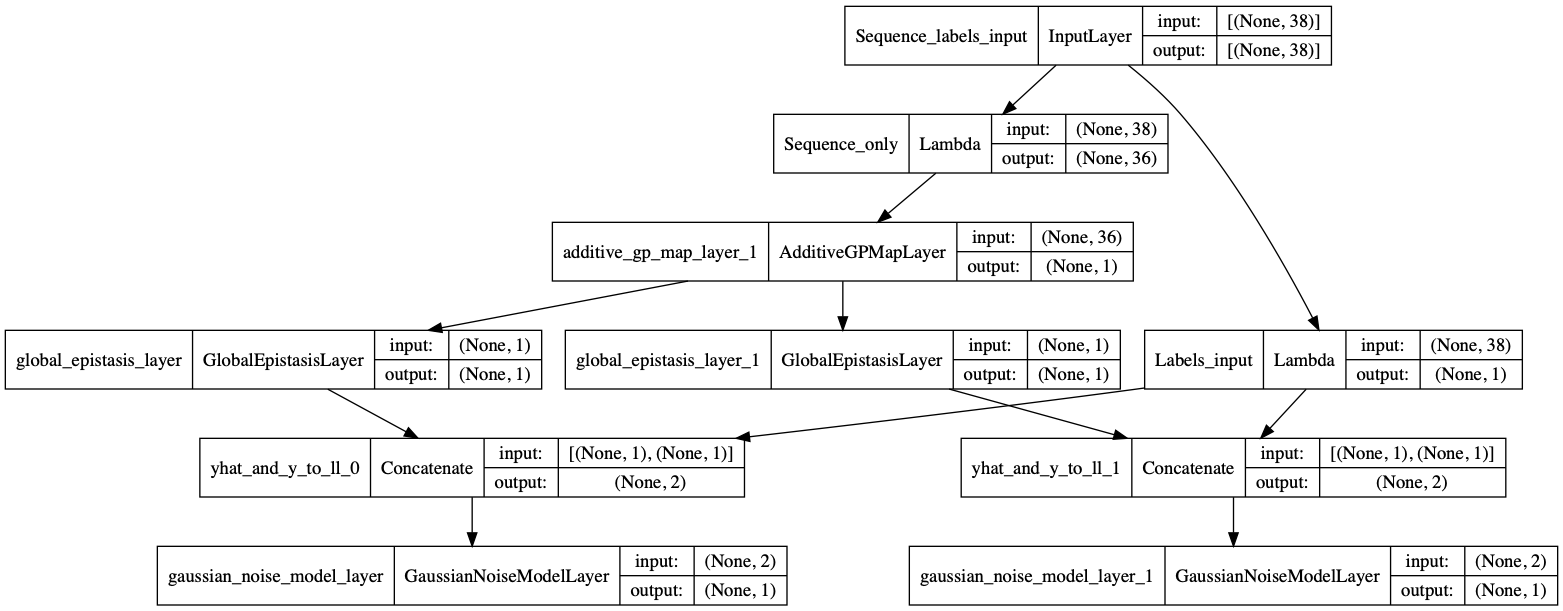

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True)

Each measurement can call it's specific $\phi$ to $y$ functions:

In [13]:
mp_GE_1.phi_to_yhat(phi)

<tf.Tensor: shape=(6078, 1), dtype=float32, numpy=
array([[-1.856774  ],
       [ 0.58156294],
       [-1.6208525 ],
       ...,
       [-1.8917221 ],
       [-1.8931546 ],
       [ 0.8366293 ]], dtype=float32)>

In [14]:
mp_GE_2.p_of_y_given_phi(phi,y_test)

<tf.Tensor: shape=(6078, 6078), dtype=float32, numpy=
array([[0.37789473, 0.04240765, 0.30667424, ..., 0.28378165, 0.3371368 ,
        0.05877217],
       [0.26861337, 0.29551625, 0.35027298, ..., 0.36790112, 0.32144573,
        0.3318702 ],
       [0.3946056 , 0.05522777, 0.335273  , ..., 0.31407169, 0.36219224,
        0.07499764],
       ...,
       [0.3749586 , 0.04072371, 0.30223003, ..., 0.27916184, 0.33311224,
        0.05660881],
       [0.3748359 , 0.04065582, 0.30204692, ..., 0.27897197, 0.33294576,
        0.05652143],
       [0.23431997, 0.32731664, 0.32109565, ..., 0.34175438, 0.28915542,
        0.35958382]], dtype=float32)>

## Prepare data with two targets 
In this case two replicate PSI measurements for BRCA2

In [15]:
MPSA_data_lib1_rep1 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep1.csv')
MPSA_data_lib1_rep2 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep2.csv')

In [16]:
#BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep3,on='ss',how='outer')
BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep2,on='ss',how='outer').copy()
BRCA_df = BRCA_df[['ss', 'log_psi_x', 'log_psi_y']].copy()
BRCA_df.columns = ['x','y1','y2']

# drop nans for now, though in future this should be allowed. 
BRCA_df.dropna(inplace=True)

# split into train-val-test sets. 
np.random.seed(0)
BRCA_df['set'] = np.random.choice(a=['training', 'validation', 'test'], 
                                   p=[.8,.1,.1], 
                                   size=len(BRCA_df))
BRCA_df

,x,y1,y2,set
0,AAAGCAAAA,-3.751854,-3.115981,training
1,AAAGCAAAC,-2.697741,-2.991176,training
2,AAAGCAAAG,-2.242947,-2.666159,training
3,AAAGCAAAT,-3.067251,-2.823078,training
4,AAAGCAACA,-2.987074,-2.489996,training
...,...,...,...,...
21924,TTTGTTTCT,-3.265759,-3.776585,training
21925,TTTGTTTGA,-2.729585,-3.509597,training
21926,TTTGTTTGG,-2.944439,-3.079346,training
21927,TTTGTTTGT,-3.267212,-3.325882,training


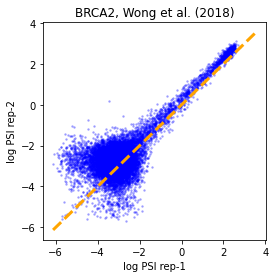

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(BRCA_df['y1'],BRCA_df['y2'],s=2.5,color='blue',alpha=0.25)
ax.set_xlabel('log PSI rep-1')
ax.set_ylabel('log PSI rep-2')
ax.set_title('BRCA2, Wong et al. (2018)')
lims = ax.get_ylim()
ax.plot(lims,lims,linestyle='--',color='orange',lw=3)

## Set data 

In [18]:
# Set training data
model.set_data(x=BRCA_df['x'],
               y=BRCA_df[['y1','y2']],
               validation_flags=(BRCA_df['set']=='validation'),
               shuffle=False)

N = 21,466 observations set as training data.
Using 9.9% for validation.
Time to set data: 0.139 sec.


In [19]:
model.y_norm

,y1,y2
0,-3.751854,-3.115981
1,-2.697741,-2.991176
2,-2.242947,-2.666159
3,-3.067251,-2.823078
4,-2.987074,-2.489996
...,...,...
21924,-3.265759,-3.776585
21925,-2.729585,-3.509597
21926,-2.944439,-3.079346
21927,-3.267212,-3.325882


Note that linear initialization currently won't work with more than one y target

In [20]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=100,
                    early_stopping=True,
                    linear_initialization=False)

Epoch 1/100
387/387 [==============================] - 4s 5ms/step - loss: 525.2469 - gaussian_noise_model_layer_loss: 271.6949 - gaussian_noise_model_layer_1_loss: 253.5458 - I_var: nan - val_loss: 336.8825 - val_gaussian_noise_model_layer_loss: 174.7663 - val_gaussian_noise_model_layer_1_loss: 162.1103 - val_I_var: nan
Epoch 2/100
387/387 [==============================] - 1s 3ms/step - loss: 213.3665 - gaussian_noise_model_layer_loss: 110.3820 - gaussian_noise_model_layer_1_loss: 102.9787 - I_var: nan - val_loss: 174.7618 - val_gaussian_noise_model_layer_loss: 87.7970 - val_gaussian_noise_model_layer_1_loss: 86.9590 - val_I_var: nan
Epoch 3/100
387/387 [==============================] - 1s 1ms/step - loss: 169.4244 - gaussian_noise_model_layer_loss: 84.9619 - gaussian_noise_model_layer_1_loss: 84.4567 - I_var: nan - val_loss: 167.4906 - val_gaussian_noise_model_layer_loss: 83.9369 - val_gaussian_noise_model_layer_1_loss: 83.5478 - val_I_var: nan
Epoch 4/100
387/387 [================

Epoch 27/100
387/387 [==============================] - 1s 2ms/step - loss: 163.6493 - gaussian_noise_model_layer_loss: 81.8087 - gaussian_noise_model_layer_1_loss: 81.8327 - I_var: nan - val_loss: 163.8182 - val_gaussian_noise_model_layer_loss: 81.9079 - val_gaussian_noise_model_layer_1_loss: 81.9025 - val_I_var: nan
Epoch 28/100
387/387 [==============================] - 1s 2ms/step - loss: 163.7146 - gaussian_noise_model_layer_loss: 81.8344 - gaussian_noise_model_layer_1_loss: 81.8723 - I_var: nan - val_loss: 163.8464 - val_gaussian_noise_model_layer_loss: 81.9130 - val_gaussian_noise_model_layer_1_loss: 81.9256 - val_I_var: nan
Epoch 29/100
387/387 [==============================] - 1s 2ms/step - loss: 163.6776 - gaussian_noise_model_layer_loss: 81.8240 - gaussian_noise_model_layer_1_loss: 81.8457 - I_var: nan - val_loss: 163.8123 - val_gaussian_noise_model_layer_loss: 81.9008 - val_gaussian_noise_model_layer_1_loss: 81.9036 - val_I_var: nan
Epoch 30/100
387/387 [==================

Epoch 53/100
387/387 [==============================] - 1s 1ms/step - loss: 117.5505 - gaussian_noise_model_layer_loss: 58.7464 - gaussian_noise_model_layer_1_loss: 58.7943 - I_var: nan - val_loss: 120.5536 - val_gaussian_noise_model_layer_loss: 60.2665 - val_gaussian_noise_model_layer_1_loss: 60.2772 - val_I_var: nan
Epoch 54/100
387/387 [==============================] - 1s 1ms/step - loss: 117.5284 - gaussian_noise_model_layer_loss: 58.7390 - gaussian_noise_model_layer_1_loss: 58.7794 - I_var: nan - val_loss: 120.6896 - val_gaussian_noise_model_layer_loss: 60.3539 - val_gaussian_noise_model_layer_1_loss: 60.3257 - val_I_var: nan
Epoch 55/100
387/387 [==============================] - 1s 1ms/step - loss: 117.5633 - gaussian_noise_model_layer_loss: 58.7539 - gaussian_noise_model_layer_1_loss: 58.7993 - I_var: nan - val_loss: 120.5555 - val_gaussian_noise_model_layer_loss: 60.2730 - val_gaussian_noise_model_layer_1_loss: 60.2723 - val_I_var: nan
Epoch 56/100
387/387 [==================

Epoch 79/100
387/387 [==============================] - 1s 3ms/step - loss: 117.4288 - gaussian_noise_model_layer_loss: 58.6923 - gaussian_noise_model_layer_1_loss: 58.7255 - I_var: nan - val_loss: 120.6636 - val_gaussian_noise_model_layer_loss: 60.3364 - val_gaussian_noise_model_layer_1_loss: 60.3163 - val_I_var: nan
Epoch 80/100
387/387 [==============================] - 1s 2ms/step - loss: 117.4100 - gaussian_noise_model_layer_loss: 58.6808 - gaussian_noise_model_layer_1_loss: 58.7182 - I_var: nan - val_loss: 120.5013 - val_gaussian_noise_model_layer_loss: 60.2374 - val_gaussian_noise_model_layer_1_loss: 60.2530 - val_I_var: nan
Epoch 81/100
387/387 [==============================] - 1s 1ms/step - loss: 117.3524 - gaussian_noise_model_layer_loss: 58.6567 - gaussian_noise_model_layer_1_loss: 58.6848 - I_var: nan - val_loss: 120.7330 - val_gaussian_noise_model_layer_loss: 60.3575 - val_gaussian_noise_model_layer_1_loss: 60.3646 - val_I_var: nan
Epoch 82/100
387/387 [==================

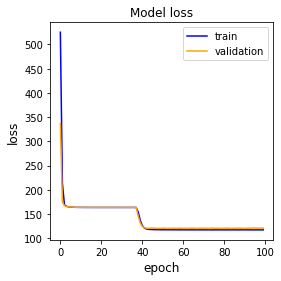

In [21]:
plt.figure(figsize=(4,4))
plt.plot(model.history['loss'], color='blue')
plt.plot(model.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

In [22]:
# phi = gpmap.x_to_phi(x_test)
# mp_GE.phi_to_yhat(phi)
test_df = BRCA_df[BRCA_df['set']=='test'].reset_index(drop=True).copy()
x_test = test_df['x']
y1_test = test_df['y1']
y2_test = test_df['y2']

In [23]:
phi = gpmap.x_to_phi(x_test)

yhat1 = mp_GE_1.phi_to_yhat(phi)
yhat2 = mp_GE_2.phi_to_yhat(phi)

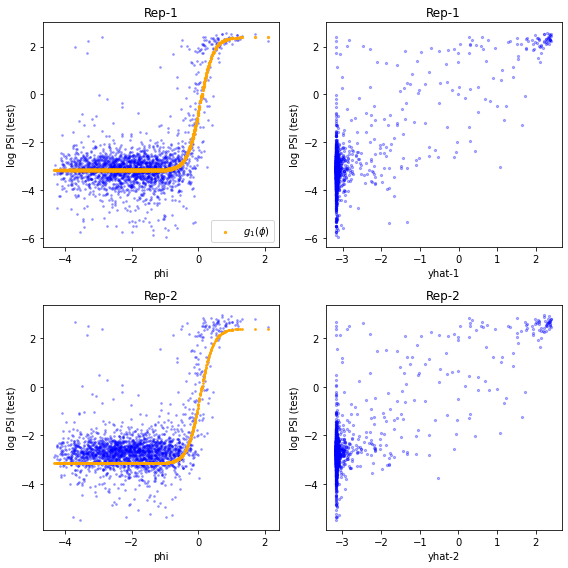

In [24]:

fig, axs = plt.subplots(2,2,figsize=(8,8))

ax = axs[0,0]

ax.scatter(phi,y1_test,s=3,alpha=0.3,c='blue')
ax.scatter(phi,yhat1,s=5,alpha=0.9,c='orange',label=f'$g_{1}(\phi)$')

ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.legend()

ax = axs[0,1]

ax.scatter(yhat1,y1_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-1')


ax = axs[1,0]
ax.scatter(phi,y2_test,s=3,alpha=0.3,c='b')
ax.scatter(phi,yhat2,s=3,alpha=0.9,c='orange',label=f'$g_{2}(\phi)$')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.set_title('Rep-2')

ax = axs[1,1]

ax.scatter(yhat2,y2_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-2')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-2')


fig.tight_layout()